# Simple Linear Regression and Bootstrapping Method

We can use the bootstrap method to get regression models. Bootstrapping a regression model gives insight into how variable the model parameters are. It is helpful to know how much random variation in regression coefficients is due to small data values change. 

It is possible to bootstrap almost any regression model, but it can be computationally intensive.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid")

## The Data

In [2]:
df = pd.read_csv('salary_data.csv')
print(df.shape)
df.head()

(30, 2)


,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


## The Model

In [3]:
x = np.array(df.YearsExperience)
y = np.array(df.Salary)

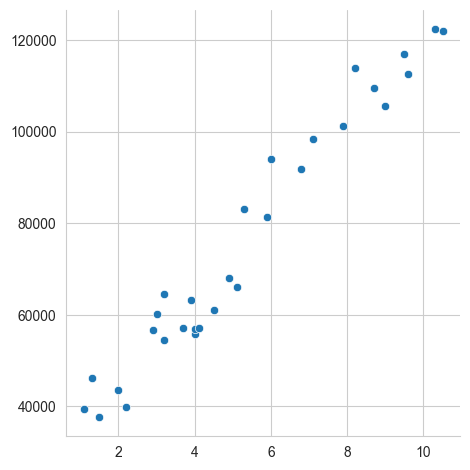

In [4]:
sns.relplot(data=df, x=x, y=y);  

In [5]:
# Adding the constant term
Xc = sm.add_constant(x)

In [6]:
# Defining the Ordinary Least Squares model and fitting it
model = sm.OLS(y, Xc).fit()

In [7]:
# Getting the estimated parameters
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     622.5
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           1.14e-20
Time:                        19:04:52   Log-Likelihood:                -301.44
No. Observations:                  30   AIC:                             606.9
Df Residuals:                      28   BIC:                             609.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.579e+04   2273.053     11.347      0.000    2.11e+04    3.04e+04
x1          9449.9623    378.755     24.950      0.000    8674.119    1.02e+04
==============================================================================
Omnibus:                        2.140   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.343   Jarque-Bera (JB):                1.569
Skew:                           0.363   Prob(JB):                        0.456
Kurtosis:                       2.147   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
print('Coefficient of determination: %.3f' %(model.rsquared))

Coefficient of determination: 0.957


In [9]:
intercept = model.params[0] 
slope     = model.params[1] 

In [10]:
# Printing the model
eq = 'Model: Salary = %.2f * YearsExperience + %.2f' %(slope, intercept)
eq

'Model: Salary = 9449.96 * YearsExperience + 25792.20'

In [11]:
# Getting the predicted values
df['predict'] = model.predict()
df.head(3)

,YearsExperience,Salary,predict
0,1.1,39343,36187.158752
1,1.3,46205,38077.151217
2,1.5,37731,39967.143681


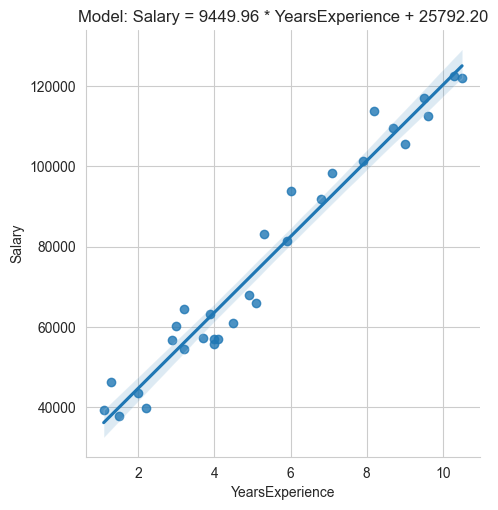

In [12]:
sns.lmplot(data=df, x = 'YearsExperience', y = 'Salary')
ax = plt.gca()
ax.set_title(eq);

## Bootstrapping Method

Let's perform a parametric resampling.

We are going to resample WITH replacement each row.

In [13]:
def get_boot_simple_regressions(x, y, num_samples=10000):
    '''
    It returns two NumPy arrays with the sample distributions for slope and intercept.
    '''
    sample_size = len(x)        
    x = np.array(x)
    y = np.array(y)

    def get_model():
        idx = np.random.choice(range(sample_size), replace=True, size=sample_size)
        xi = x[idx]
        yi = y[idx]        
        xic = sm.add_constant(xi)
        modeli = sm.OLS(yi, xic).fit()        
        return modeli.params[1], modeli.params[0]
    
    results = [get_model() for _ in range(num_samples)]

    slopeSD, intercSD = zip(*results)
    return np.array(slopeSD), np.array(intercSD)

In [14]:
slope_sample_distribution, interc_sample_distribution = get_boot_simple_regressions(x, y)

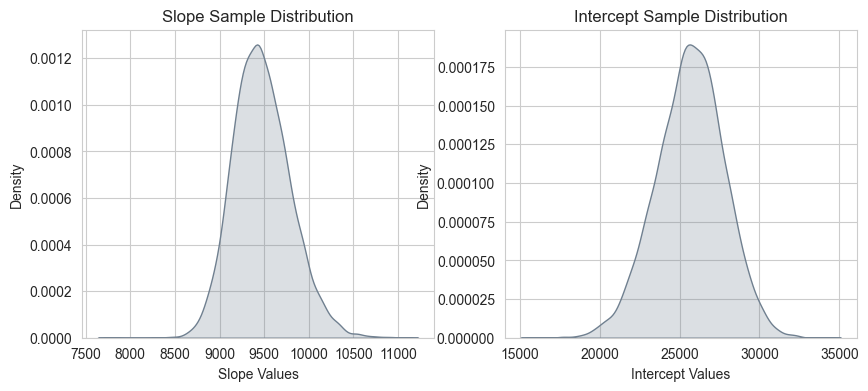

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.kdeplot(slope_sample_distribution, fill=True, color='slategrey').set(
    title='Slope Sample Distribution', xlabel='Slope Values', ylabel='Density')

plt.subplot(122)
sns.kdeplot(interc_sample_distribution, fill=True, color='slategrey').set(
    title='Intercept Sample Distribution', xlabel='Intercept Values', ylabel='Density');

### Bootstrap Hypothesis Test for the model

To determine whether the model is significant, we can compute the confidence interval of the slope and analyze if it contains the zero value.

In [16]:
def confidence_interval(sample_distribution, confidence):
    '''
    This function return a confidence% confidente interval using 
    sample_distribution as a sample distribution.
    '''
    alpha = 100 - confidence
    lower_percentile = alpha / 2.0    
    lower_limit = np.percentile(sample_distribution, lower_percentile)
    upper_percentile = lower_percentile + confidence
    upper_limit = np.percentile(sample_distribution, upper_percentile)
    return(lower_limit, upper_limit)

In [17]:
# Getting confidence intervals for the slope 
print('90%% Confidence Interval for slope = (%.2f, %.2f)' 
            % confidence_interval(slope_sample_distribution, 90))
print('95%% Confidence Interval for slope = (%.2f, %.2f)' 
            % confidence_interval(slope_sample_distribution, 95))
print('99%% Confidence Interval for slope = (%.2f, %.2f)' 
            % confidence_interval(slope_sample_distribution, 99))

90% Confidence Interval for slope = (8980.71, 10032.54)
95% Confidence Interval for slope = (8894.15, 10158.70)
99% Confidence Interval for slope = (8732.48, 10427.10)


If the confidence interval for the slope of a simple linear regression model does not include zero, it indicates that there is a statistically significant relationship between the predictor variable and the response variable. In other words, we can be reasonably confident that the slope is different from zero, suggesting that changes in the predictor variable are associated with changes in the response variable.

This is a crucial point for hypothesis testing. Typically, the null hypothesis states that there is no effect (i.e., the slope is zero). If the confidence interval excludes zero, you have evidence to reject the null hypothesis in favor of the alternative hypothesis, which posits that there is an effect (i.e., the slope is not zero). Thus, our findings would be considered statistically significant. 

We also can use our hypothesis test functions.

In [18]:
def get_p_value(sample_distribution, obs_value, alternative='two-sided'):    
    '''
    It returns the p-value.
    sample_distribution:    the sample distribution
    obs_value:              the observed value     
    alternative:            'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2*min(ecdf(obs_value), 1 - ecdf(obs_value))        
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [19]:
def graph_hyp_test(sample_value, sample_distribution, alpha=0.05, alternative='two-sided'):
    '''
    It computes and graph the two-samples hypothesis test.
    sample_value:           observed value calculated from the sample
    sample_distribution:    sample distribution calculated from the sample
    alpha:                  significance level
    alternative:            'two-sided', 'smaller', and 'larger'
    '''
    print('--- Hypothesis Test ---')
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution, color='skyblue', fill=True).set_title('Sample Distribution')  
    # plotting the statistic
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)       
    # get the p-value
    p_val = get_p_value(sample_distribution, sample_value, alternative)
    # plotting the two critical regions
    if alternative=='two-sided':        
        cv1 = np.round(np.percentile(sample_distribution, (alpha/2)*100),2)         # left critical value    
        cv2 = np.round(np.percentile(sample_distribution, 100-(alpha/2)*100),2)     # right critical value    
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    # plotting the left critical region
    elif alternative=='smaller':        
        cv1 = np.round(np.percentile(sample_distribution, alpha*100),2)             # left critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # plotting the right critical region
    else:                               
        cv2 = np.round(np.percentile(sample_distribution, 100-alpha*100),2)         # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # printing the statistic and the p-value    
    print('Observed Value = %.2f\tp-value = %.4f' %(sample_value, p_val))  

We are interested in determining whether the model' slope is significantly different from 0.

--- Hypothesis Test ---


Observed Value = 0.00	p-value = 0.0000


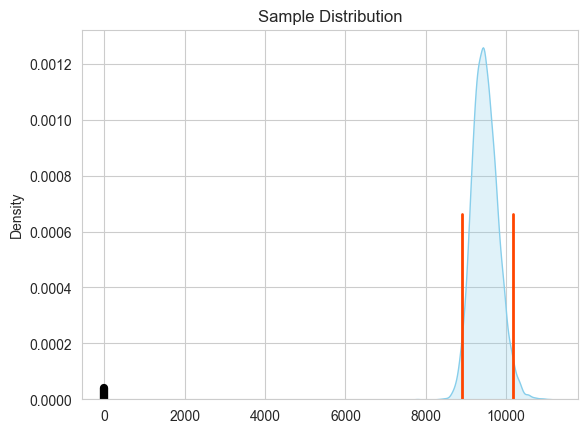

In [20]:
graph_hyp_test(0, slope_sample_distribution)

The model is significant!

### Plotting the Bootstrap Regression Models

Let's create a function for creating and ploting the bootstrap models.

In [21]:
def plot_boot_reg_models(x, y, slopeSD, interceptSD):
    """
    Plots multiple models defined by slopeSD and interceptSD in grey,
    and computes and plots the original linear regression model from x and y in red.
    """
    # Generate the x values for the plot
    x_values = np.linspace(min(x), max(x), 50)

    # Getting the model
    xc = sm.add_constant(x)
    model = sm.OLS(y, xc).fit()
    slope, intercept = model.params[1], model.params[0]

    # Plot each model from slopeSD and interceptSD in grey
    for m, b in zip(slopeSD, interceptSD):
        plt.plot(x_values, m * x_values + b, color='slategrey', linewidth=1, alpha=0.2)

    # Plot the model defined by slope and intercept in red
    plt.plot(x_values, slope * x_values + intercept, color='darkred', linewidth=2)    
    plt.scatter(x, y, color='darkred', s=15)

    # Add labels and title for clarity
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.title("%d Bootstrap Regression Models" %len(slopeSD))

    # Show the plot
    plt.show()

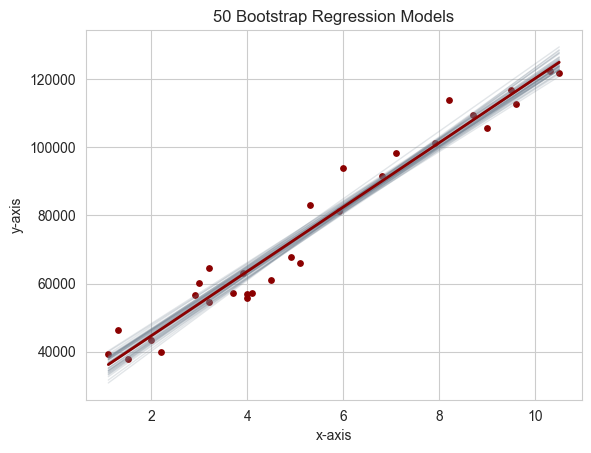

In [22]:
# Plotting the first 50 models
plot_boot_reg_models(x, y, slope_sample_distribution[:50], interc_sample_distribution[:50])

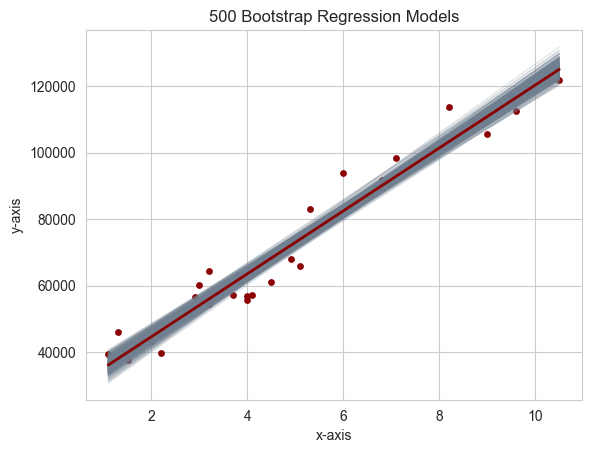

In [23]:
# Plotting the first 500 models
plot_boot_reg_models(x, y, slope_sample_distribution[:500], interc_sample_distribution[:500])

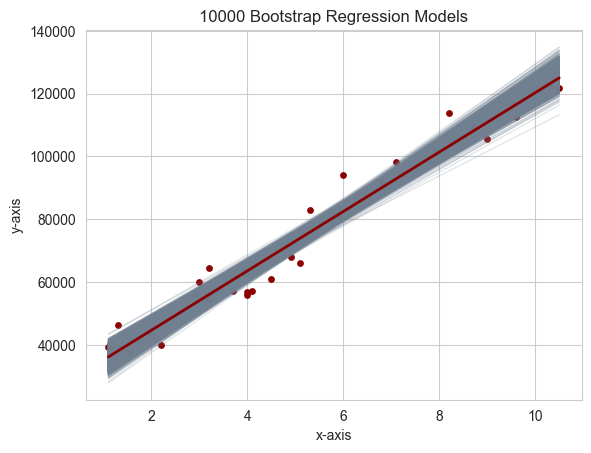

In [24]:
# Plotting all computed models
plot_boot_reg_models(x, y, slope_sample_distribution, interc_sample_distribution)

The bands are around the center because most data are near the center rather than at the edges.

## Bootstrapping Method 2

The idea here is to work with the residuals. Remember one of the regression assumptions is that the errors or residuals are independent and identically distributed (IID) among our data.

In [25]:
# Computing the residuals
df['resids'] = model.resid
df.head()

,YearsExperience,Salary,predict,resids
0,1.1,39343,36187.158752,3155.841248
1,1.3,46205,38077.151217,8127.848783
2,1.5,37731,39967.143681,-2236.143681
3,2.0,43525,44692.124842,-1167.124842
4,2.2,39891,46582.117306,-6691.117306


Now we generate `num_samples` new sets of data by sampling the residuals WITH replacement and adding them to the fitted values.

In [26]:
def get_boot_simple_regressions_2(x, y, num_samples=10000):
    '''
    It returns two NumPy arrays with the sample distributions for slope and intercept.
    '''
    sample_size = len(x)        
    x = np.array(x)
    y = np.array(y)
    xc = sm.add_constant(x)
    model = sm.OLS(y,xc).fit()      # define and fit the model
    yPred = model.predict()         # getting the predictions
    resids = model.resid              # getting the residuals

    boot_results = [(
            sm.OLS([yPredi + np.random.choice(resids) for yPredi in yPred], xc).fit().params[1],
            sm.OLS([yPredi + np.random.choice(resids) for yPredi in yPred], xc).fit().params[0])
        for _ in range(num_samples)]

    slopeSD, intercSD = zip(*boot_results)
    
    return np.array(slopeSD), np.array(intercSD)

In [27]:
slope_sample_distribution_2, interc_sample_distribution_2 = get_boot_simple_regressions_2(x, y)

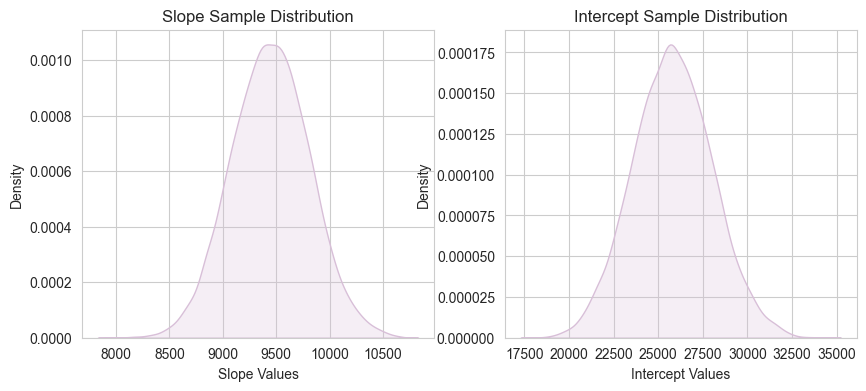

In [28]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.kdeplot(slope_sample_distribution_2, fill=True, color='thistle').set(
    title='Slope Sample Distribution', xlabel='Slope Values', ylabel='Density')

plt.subplot(122)
sns.kdeplot(interc_sample_distribution_2, fill=True, color='thistle').set(
    title='Intercept Sample Distribution', xlabel='Intercept Values', ylabel='Density');

--- Hypothesis Test ---
Observed Value = 0.00	p-value = 0.0000


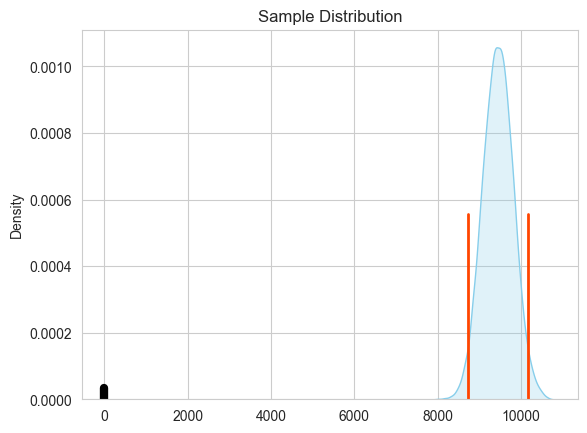

In [29]:
graph_hyp_test(0, slope_sample_distribution_2)

The model is significant!

### Plotting the Bootstrap Regression Models

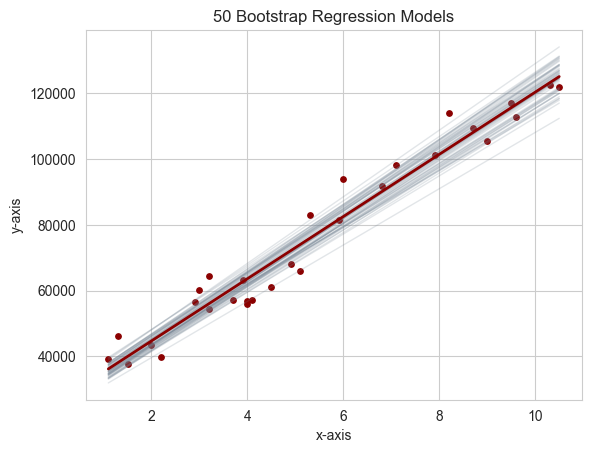

In [30]:
# Plotting the first 50 models
plot_boot_reg_models(x, y, slope_sample_distribution_2[:50], interc_sample_distribution_2[:50])

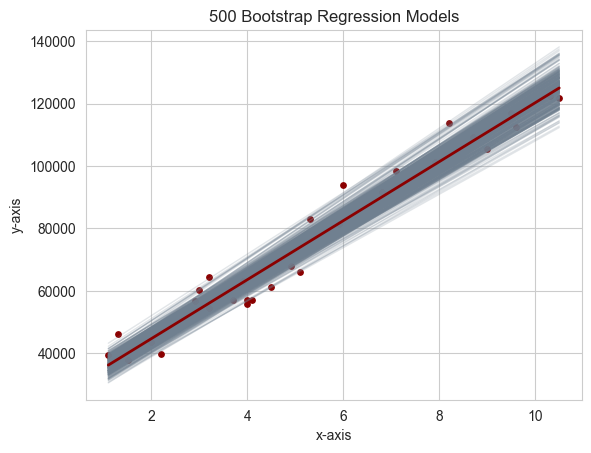

In [31]:
# Plotting the first 500 models
plot_boot_reg_models(x, y, slope_sample_distribution_2[:500], interc_sample_distribution_2[:500])

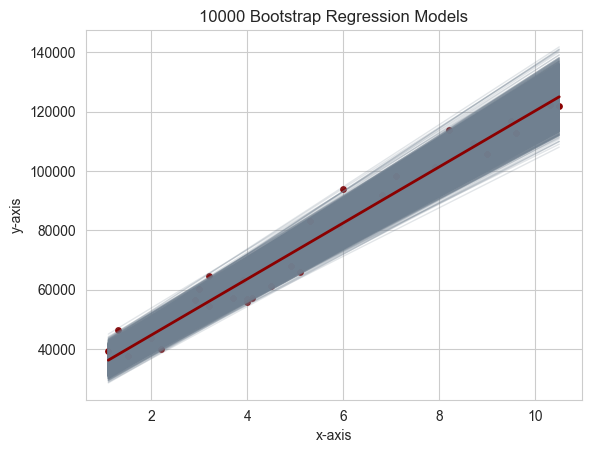

In [32]:
# Plotting all computed models
plot_boot_reg_models(x, y, slope_sample_distribution_2, interc_sample_distribution_2)

## References

- https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9
- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc. chapter 4.